<a href="https://colab.research.google.com/github/pedromasb/tutorials/blob/main/notebooks/VO_with_python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><center> VO with Python: working with PyVO and MOCPy </center></h1>

Created by

**Pedro Mas Buitrago, [SVO](https://svo.cab.inta-csic.es/main/index.php)**

**Last updated** by the author in March 2023

This tutorial has taken some references from the adaptation of "[Advanced usage of HiPS and MOCs to explore complex regions of interest](https://github.com/cds-astro/tutorials/tree/master/Notebooks)" to jupyter notebook by the Strasbourg astronomical Data Center ([CDS](https://cdsweb.u-strasbg.fr/)) team.

For the tutorial to work correctly, the user must upload [these data files](https://github.com/pedromasb/tutorials/tree/main/notebooks/data/vo_with_python_data) in their own Google Colab session. To do this, click on the "Files" icon on the left side of the page, select the "Upload to session storage" option (first icon in the pop-up menu) and upload the files from the local directory.

---

<h2><center> Technical background </center></h2>

The Multi-Order Coverage map (**MOC**) is a Virtual Observatory method created to specify any kind of sky region in a simple and efficient way. As mentioned in the [reference document](https://www.ivoa.net/documents/MOC/20220727/REC-moc-2.0-20220727.pdf), the rationale behind MOC is to get a method to manipulate sky coverages in order to provide very fast union, intersection and equality operations between them.

The MOC method is based on the [HEALPix](https://iopscience.iop.org/article/10.1086/427976) tesselation technique, a method of partitioning the sphere that consists of diamond cells with equal spherical surfaces. The HEALPix tessellation technique divides the sphere into 12 cells, each of them sub-divided into 4 cells recursively (see Fig. 1). Thus the sphere at order 1 will consist of 48 cells, 192 cells at order 2, 768 at order 3 and so on where each cell at a given order is covering an equal area of the sphere.

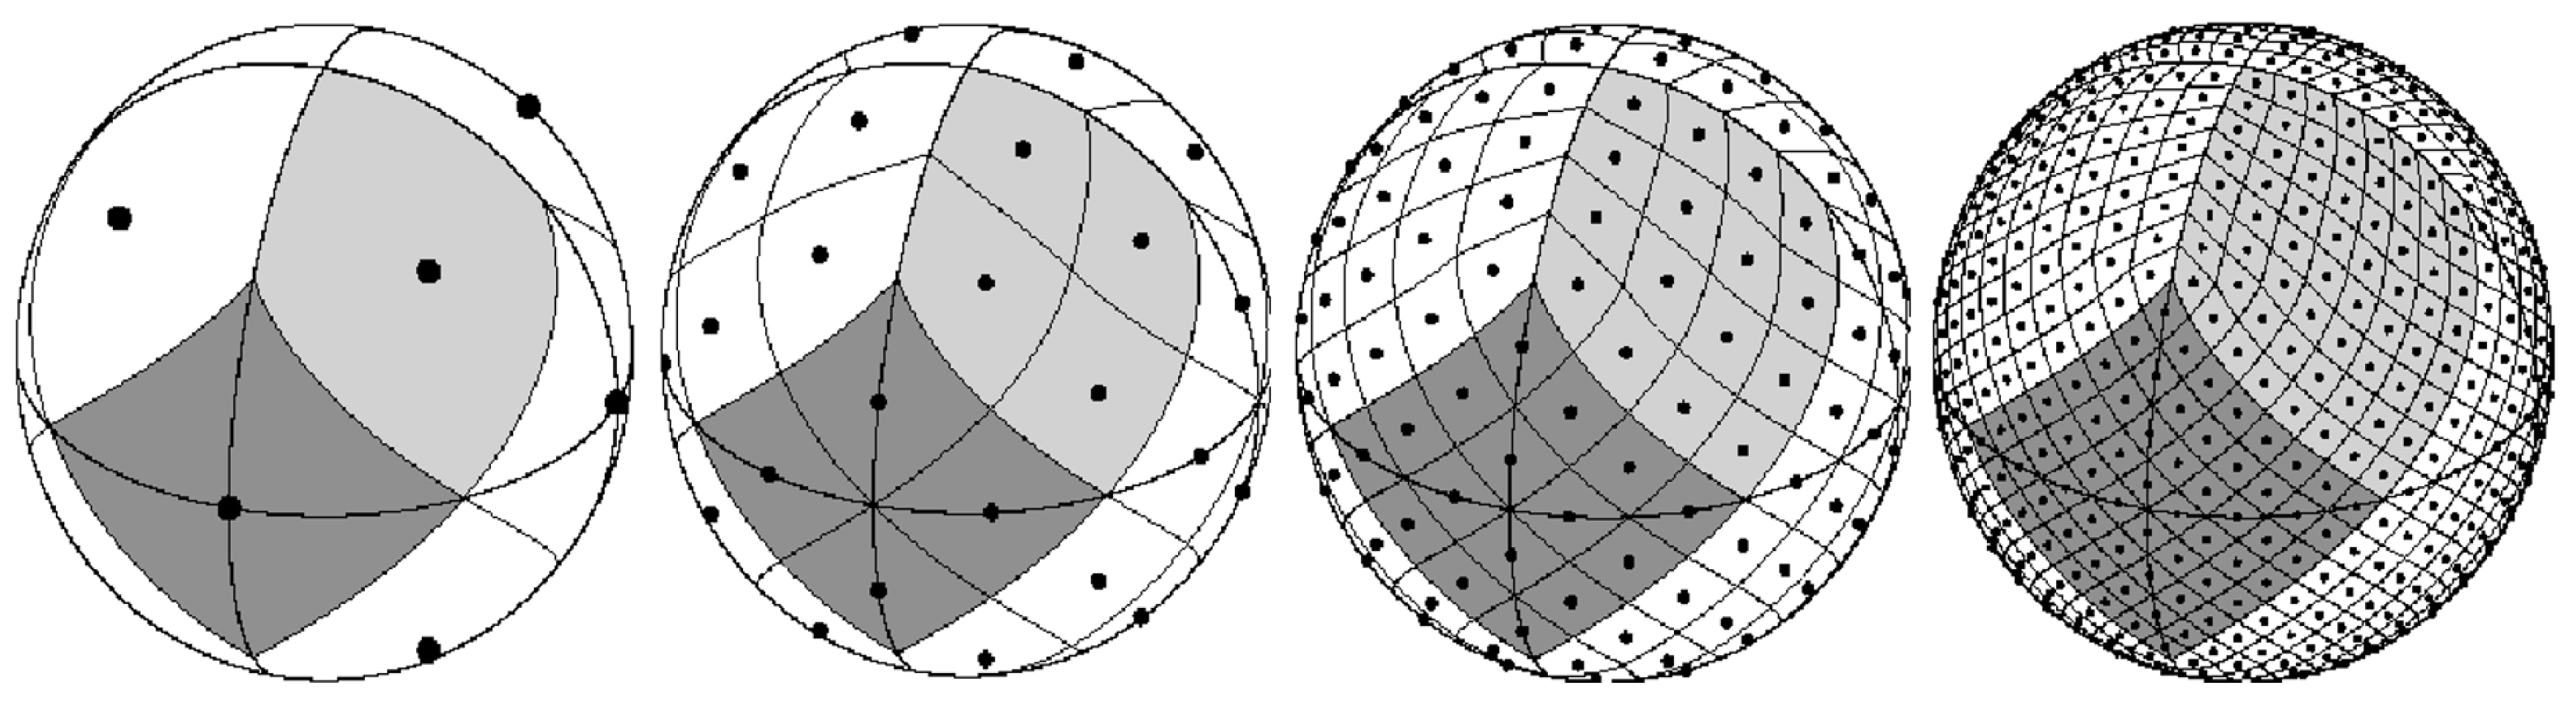

In [ ]:
from IPython.display import Image
Image('healpix.png',width=950, height=250)

<center> Fig. 1: HEALPix partition of the sphere. The corresponding HEALPix order is 0, 1, 2 and 3, from left to right.  </center>

---

<h2><center> Before we get started </center></h2>

This is a hands-on tutorial demonstrating the usage of PyVO and MOCPy, two products for accessing the VO from Python, in which we will:

1. Learn to access astronomical data using PyVO
2. Work with Multi-Order Coverage (MOC) maps from different surveys using MOCPy
3. See how the use of MOCs can benefit a real scientific case
4. Retrieve objects from large catalogs using a specific MOC

We will use the python packages included in the file `requirements.txt`. The python packages include [MOCPy](https://github.com/cds-astro/mocpy), [astroquery](https://astroquery.readthedocs.io/en/latest/), [PyVO](https://pyvo.readthedocs.io/en/latest/), [astropy](https://docs.astropy.org/en/stable/index.html), [pandas](https://pandas.pydata.org/docs/), [numpy](https://numpy.org/doc/stable/) and [matplotlib](https://matplotlib.org/stable/index.html).

To install these packages:

In [ ]:
! pip install -r /content/requirements.txt

First of all, we will import these packages!

In [ ]:
import warnings
import pandas as pd
import numpy as np
import pyvo
import matplotlib.pyplot as plt
from mocpy import MOC, World2ScreenMPL

from astropy.coordinates import Angle, SkyCoord
import astropy.units as u
from astroquery.vizier import Vizier
import plotly.express as px

We will also make use of the [VizieR](https://vizier.cds.unistra.fr/viz-bin/VizieR) service at [CDS](https://cdsweb.u-strasbg.fr/), which allows you to look for astronomical catalogues that have been published in the literature. Some of these catalogs contain data, associated with the publications, that can be consulted through the VizieR-associated data service.

---

<h2><center> Accesing data with PyVO </center></h2>

`PyVO` is an affiliated package for the `astropy` package that lets you find and retrieve astronomical data available from archives that support standard IVOA virtual observatory service protocols. In this section, we will explore the Table Access Protocol ([TAP](https://www.ivoa.net/documents/TAP/20190927/REC-TAP-1.1.pdf)), which allows access to source catalogs using [ADQL](http://docs.g-vo.org/adql/html/index.html) queries.

All TAP services must support a set of tables in a schema named TAP_SCHEMA that describes the tables and columns included in the service. In particular, the table TAP_SCHEMA.tables must contain the following columns:

<center>

| Column name | Type | not-null |
| :-: | :-: | :-: |
| schema_name | string | true |
| table_name | string | true |
| table_type | string | true |
| utype | string | false |
| description | string | false |
| table_index | integer | false |

</center>

In our case, we will use PyVO to retrieve data from the Gaia data release 3. To search for Gaia data, we will use the TAP with the Gaia endpoint. First, let's see which schemas (and information) are available in the gaia database.

In [ ]:
tap_gaia = pyvo.dal.TAPService("https://gea.esac.esa.int/tap-server/tap")

query = '''
SELECT DISTINCT schema_name, table_type
FROM tap_schema.tables
'''

gaia_info = tap_gaia.search(query).to_table()

gaia_info

schema_name,table_type
object,object
external,table
gaiadr1,table
gaiadr2,table
gaiadr3,table
gaiadr3,view
gaiaedr3,table
public,table
tap_config,table
tap_schema,table


> In a database, a **View** is a virtual table whose content is defined by a query to one or more tables. The main advantage of a view is that it can join data from several tables, avoiding repeating complex queries.

For this tutorial, we are interested in the tables from the schema `gaiadr3` containing the information about the observed sources, so we search for them:

In [ ]:
tap_gaia = pyvo.dal.TAPService("https://gea.esac.esa.int/tap-server/tap")

query = '''
SELECT *
FROM tap_schema.tables
WHERE schema_name = 'gaiadr3'
AND table_name LIKE '%source%'
AND table_type = 'table'
'''

gaia_info = tap_gaia.search(query).to_table()
gaia_info

db_table_name,description,schema_name,size,size_bytes,table_index,table_name,table_type,utype
object,object,object,int64,int64,int32,object,object,object
,"Some photometric science alerts mix transits from their primary source and other sources in the catalogue. This is done when those sources are believed to be associated with a single, astrophysical source.\n\nThis table lists the identifier for these mixed-in sources, linking them to the primary sourceIds listed in table \texttt{ScienceAlerts}.",gaiadr3,94,57344,-1,gaiadr3.alerts_mixedin_sourceids,table,
,This table contains data related to Solar System objects observed by Gaia. The quantities in the table are derived from data reduction and are associated to single objects.,gaiadr3,158152,20758528,-1,gaiadr3.sso_source,table,
,"This table has an entry for every Gaia observed source as published with this data release. It contains the basic source parameters, in their final state as processed by the Gaia Data Processing and Analysis Consortium from the raw data coming from the spacecraft. The table is complemented with others containing information specific to certain kinds of objects (e.g.~Solar--system objects, non--single stars, variables etc.) and value--added processing (e.g.~astrophysical parameters etc.). Further array data types (spectra, epoch measurements) are presented separately via Datalink resources.",gaiadr3,1811709771,3646930329600,-1,gaiadr3.gaia_source,table,
,"This is a column-wise subset of the gaia_source table named gaia_source_lite. This table has an entry for every Gaia observed source as published with this data release. It contains the basic source parameters, in their final state as processed by the Gaia Data Processing and Analysis Consortium from the raw data coming from the spacecraft. The table is complemented with others containing information specific to certain kinds of objects (e.g.~Solar--system objects, non--single stars, variables etc.) and value--added processing (e.g.~astrophysical parameters etc.). Further array data types (spectra, epoch measurements) are presented separately via Datalink resources.",gaiadr3,1811709771,2047358140416,-1,gaiadr3.gaia_source_lite,table,


As you can see in the description, the table we are looking for is `gaiadr3.gaia_source`. As a practical example, let's search for Pleiades-comoving objects with reliable parallax and proper motion (relative error less than 10$\%$).

In [ ]:
query = '''
SELECT TOP 40000 *
FROM gaiadr3.gaia_source
WHERE ABS(pmra_error/pmra) < 0.1
AND ABS(pmdec_error/pmdec) < 0.1
AND pm < 100
AND parallax_over_error > 10
AND 1=CONTAINS(
  POINT(ra,dec),
  CIRCLE(56.601,24.114,5))
'''

gaia_data = tap_gaia.search(query)

gaia_data.to_table()

solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pm,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,nu_eff_used_in_astrometry,pseudocolour,pseudocolour_error,ra_pseudocolour_corr,dec_pseudocolour_corr,parallax_pseudocolour_corr,pmra_pseudocolour_corr,pmdec_pseudocolour_corr,astrometric_matched_transits,visibility_periods_used,astrometric_sigma5d_max,matched_transits,new_matched_transits,matched_transits_removed,ipd_gof_harmonic_amplitude,ipd_gof_harmonic_phase,ipd_frac_multi_peak,ipd_frac_odd_win,ruwe,scan_direction_strength_k1,scan_direction_strength_k2,scan_direction_strength_k3,scan_direction_strength_k4,scan_direction_mean_k1,scan_direction_mean_k2,scan_direction_mean_k3,scan_direction_mean_k4,duplicated_source,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_bp_n_contaminated_transits,phot_bp_n_blended_transits,phot_rp_n_contaminated_transits,phot_rp_n_blended_transits,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_method_used,rv_nb_transits,rv_nb_deblended_transits,rv_visibility_periods_used,rv_expected_sig_to_noise,rv_renormalised_gof,rv_chisq_pvalue,rv_time_duration,rv_amplitude_robust,rv_template_teff,rv_template_logg,rv_template_fe_h,rv_atm_param_origin,vbroad,vbroad_error,vbroad_nb_transits,grvs_mag,grvs_mag_error,grvs_mag_nb_transits,rvs_spec_sig_to_noise,phot_variable_flag,l,b,ecl_lon,ecl_lat,in_qso_candidates,in_galaxy_candidates,non_single_star,has_xp_continuous,has_xp_sampled,has_rvs,has_epoch_photometry,has_epoch_rv,has_mcmc_gspphot,has_mcmc_msc,in_andromeda_survey,classprob_dsc_combmod_quasar,classprob_dsc_combmod_galaxy,classprob_dsc_combmod_star,teff_gspphot,teff_gspphot_lower,teff_gspphot_upper,logg_gspphot,logg_gspphot_lower,logg_gspphot_upper,mh_gspphot,mh_gspphot_lower,mh_gspphot_upper,distance_gspphot,distance_gspphot_lower,distance_gspphot_upper,azero_gspphot,azero_gspphot_lower,azero_gspphot_upper,ag_gspphot,ag_gspphot_lower,ag_gspphot_upper,ebpminrp_gspphot,ebpminrp_gspphot_lower,ebpminrp_gspphot_upper,libname_gspphot
,,,,yr,deg,mas,deg,mas,mas,mas,,mas / yr,mas / yr,mas / yr,mas / yr,mas / yr,,,,,,,,,,,,,,,,,mas,,,,1 / um,1 / um,1 / um,,,,,,,,mas,,,,,deg,,,,,,,,deg,deg,deg,deg,,,electron / s,electron / s,,mag,,electron / s,electron / s,,mag,,electron / s,electron / s,,mag,,,,,,,mag,mag,mag,km / s,km / s,,,,,,,,d,km / s,K,log(cm.s**-2),dex,,km / s,km / s,,mag,mag,,,,deg,deg,deg,deg,,,,,,,,,,,,,,,K,K,K,log(cm.s**-2),log(cm.s**-2),log(cm.s**-2),dex,dex,dex,pc,pc,pc,mag,mag,mag,mag,mag,mag,mag,mag,mag,
int64,object,int64,int64,float64,float64,float32,float64,float32,float64,float32,float32,float32,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,int16,float32,float32,float32,float32,int16,bool,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,float32,int16,int16,int16,float32,float32,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,bool,int16,float64,float32,float32,float32,int16,float64,float32,float32,float32,int16,float64,float32,float32,float32,float32,int16,int16,int16,int16,int16,float32,float32,float32,float32,float32,int16,int16,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,

With the attribute `fieldnames`, we can check the fields included in the output table:

In [ ]:
gaia_data.fieldnames

('solution_id',
 'designation',
 'source_id',
 'random_index',
 'ref_epoch',
 'ra',
 'ra_error',
 'dec',
 'dec_error',
 'parallax',
 'parallax_error',
 'parallax_over_error',
 'pm',
 'pmra',
 'pmra_error',
 'pmdec',
 'pmdec_error',
 'ra_dec_corr',
 'ra_parallax_corr',
 'ra_pmra_corr',
 'ra_pmdec_corr',
 'dec_parallax_corr',
 'dec_pmra_corr',
 'dec_pmdec_corr',
 'parallax_pmra_corr',
 'parallax_pmdec_corr',
 'pmra_pmdec_corr',
 'astrometric_n_obs_al',
 'astrometric_n_obs_ac',
 'astrometric_n_good_obs_al',
 'astrometric_n_bad_obs_al',
 'astrometric_gof_al',
 'astrometric_chi2_al',
 'astrometric_excess_noise',
 'astrometric_excess_noise_sig',
 'astrometric_params_solved',
 'astrometric_primary_flag',
 'nu_eff_used_in_astrometry',
 'pseudocolour',
 'pseudocolour_error',
 'ra_pseudocolour_corr',
 'dec_pseudocolour_corr',
 'parallax_pseudocolour_corr',
 'pmra_pseudocolour_corr',
 'pmdec_pseudocolour_corr',
 'astrometric_matched_transits',
 'visibility_periods_used',
 'astrometric_sigma5d_max

Rich metadata equivalent to what is found in VOTables (including unit, ucd and datatype) is available through resultset’s `getdesc()` method.

> In a VOTable, the attribute **ucd** stands for Unified Content Descriptor, and supplies a standardized classification of the physical quantity expressed in the column. 

In [ ]:
gaia_data.getdesc('parallax')

<FIELD ID="parallax" datatype="double" name="parallax" ucd="pos.parallax.trig" unit="mas"/>

Now that we can build the proper motion diagram to locate the comoving sources.

For a proper manipulation of the data, it is useful to create a pandas dataframe with the information required. In this cell, we will see how we can create this dataframe from the information contained in the output table.

In [ ]:
col_names = ['source_id','ra','dec','pmra','pmdec','pm']
data_list = []

for col in col_names:
    
    obj = gaia_data[col]
    
    x_ = obj.data.reshape(len(obj),1)
    
    data_list.append(x_)
        
gaia_data_df = pd.DataFrame(np.concatenate(data_list,axis=1),columns=col_names)
gaia_data_df['source_id'] = gaia_data_df['source_id'].astype(int)

gaia_data_df

,source_id,ra,dec,pmra,pmdec,pm
0,63449281282543744,55.844861,21.066104,-14.329500,-4.199461,14.932181
1,63449384361757440,55.857408,21.073267,-1.283899,-19.874110,19.915537
2,63449453081234560,55.840892,21.080189,-6.377584,-9.451780,11.402181
3,63449521800719488,55.773982,21.030220,19.368667,-46.283156,50.172459
4,63449556160926592,55.777385,21.050832,6.224062,3.012968,6.914978
...,...,...,...,...,...,...
39995,66776815786266240,57.201107,24.788572,-5.549696,-27.082830,27.645594
39996,66776884505742848,57.194043,24.792340,78.412332,-30.825097,84.253670
39997,66776953225382656,57.158587,24.781822,7.586707,-17.840537,19.386667
39998,65189189714845184,56.236219,23.733928,19.618989,-10.341132,22.177551


In [ ]:
fig = px.scatter(gaia_data,x='pmra',y='pmdec',template='none',color_discrete_sequence=['darkred'],width=800, height=600)
fig.update_traces(marker=dict(size=5,
                              color='rgba(164, 0, 0,0.35)'))

fig.show()

---

<center><h2> Working with MOCs in Python </h2></center>

MOCPy is a Python library that allows the manipulation of Multi-Order Coverage maps (MOCs) in a straightforward way. It is possible to load the MOCs from different sources, such as FITS files, urls or VizieR tables. Some powerful tasks that we can perform thanks to MOCPY is to compare the sky coverage of different surveys or to compute the union/intersection between them.

In this section we will explore both. First, we will see how the sky coverage of the Sloan Digital Sky Survey, [SDSS](https://www.sdss.org/), has changed over the years. Then, we will compute the union and intersection between the sky coverage of the SDSS data release 16 and the second data release of the [J-PLUS](http://www.j-plus.es/datareleases/data_release_dr2) survey.

First, we need to search for the VizieR tables that store the data corresponding to the data releases 3, 6 and 16 of SDSS. One way to search for the SDSS catalogues available on VizieR is to use the `Vizier` module in the `astroquery` package.

In [ ]:
catalog_list = Vizier.find_catalogs('SDSS DR3')
for k, v in catalog_list.items():
    print(k, ': ', v.description)

II/259 :  The SDSS Photometric Catalog, Release 3 (Abazajian+ 2005)
J/ApJ/635/123 :  The SDSS-DR3 damped Ly{alpha} survey (Prochaska+, 2005)
J/ApJ/639/766 :  SDSS-DR3 strong MgII absorbers (Prochter+, 2006)
J/ApJS/165/1 :  BAL QSOs from SDSS DR3 (Trump+, 2006)
J/ApJS/166/128 :  Narrow line Seyfert 1 galaxies from SDSS-DR3 (Zhou+, 2006)
J/ApJS/194/42 :  SDSS-DR3 MgII-based black hole masses (Rafiee+, 2011)
J/A+A/448/955 :  Abundances of emission galaxies in SDSS-DR3 (Izotov+, 2006)
J/A+A/634/A4 :  3 X-ray galaxy clusters radio images (Mandal+, 2020)
J/AJ/130/734 :  Magnetic white dwarfs from SDSS DR2 and DR3 (Vanlandingham+, 2005)
J/AJ/130/873 :  Properties of BQS objects in the SDSS DR3 area (Jester+, 2005)
J/AJ/131/2766 :  Quasar luminosity function from SDSS-DR3 (Richards+, 2006)
J/AJ/134/579 :  Morphologically classified galaxies from SDSS DR3 (Fukugita+, 2007)
J/AJ/140/817 :  SDSS-DR3 OVI QSOs absorbers (Frank+, 2010)
J/MNRAS/371/495 :  Catalogue of 1806 MgII absorbers from SDSS DR

The catalog we are looking for is `II/259 :  The SDSS Photometric Catalog, Release 3 (Abazajian+ 2005)`. To see the tables included in this catalog, we can use the `get_catalogs()` method:

In [ ]:
table_list = Vizier.get_catalogs('II/259')

table_list

TableList with 1 tables:
	'0:II/259/sdss3' with 13 column(s) and 50 row(s) 

***Exercise 1:*** *Find the corresponding tables for the remaining SDSS data releases, SDSS DR6 and SDSS DR16.*



In [ ]:
#@title
catalog_list = Vizier.find_catalogs('SDSS DR6')
for k, v in catalog_list.items():
    print(k, ': ', v.description)

warnings.filterwarnings('ignore')

In [ ]:
#@title
table_list = Vizier.get_catalogs('II/282')

table_list

In [ ]:
#@title
catalog_list = Vizier.find_catalogs('SDSS DR16')
for k, v in catalog_list.items():
    print(k, ': ', v.description)

warnings.filterwarnings('ignore')

In [ ]:
#@title
table_list = Vizier.get_catalogs('V/154')

table_list

The tables we need are `II/259/sdss3`, `II/282/sdss6` and `V/154/sdss16`. Now, we load the MOCs for the different SDSS data releases using these tables.

In [ ]:
moc_sdssdr3 = MOC.from_vizier_table('II/259/sdss3')
moc_sdssdr6 = MOC.from_vizier_table('II/282/sdss6')
moc_sdssdr16 = MOC.from_vizier_table('V/154/sdss16')

To plot the MOCs, we first need to use the `World2ScreenMPL` MOCPy class to create the astropy Word Coordinate System (WCS) that represents the field of view of the figure, as explained in the [MOCPy](https://cds-astro.github.io/mocpy/examples/examples.html) documentation.

> World Coordinate Systems (WCSs) describe the geometric transformations between one set of coordinates and another. A common application is to map the pixels in an image onto the celestial sphere.

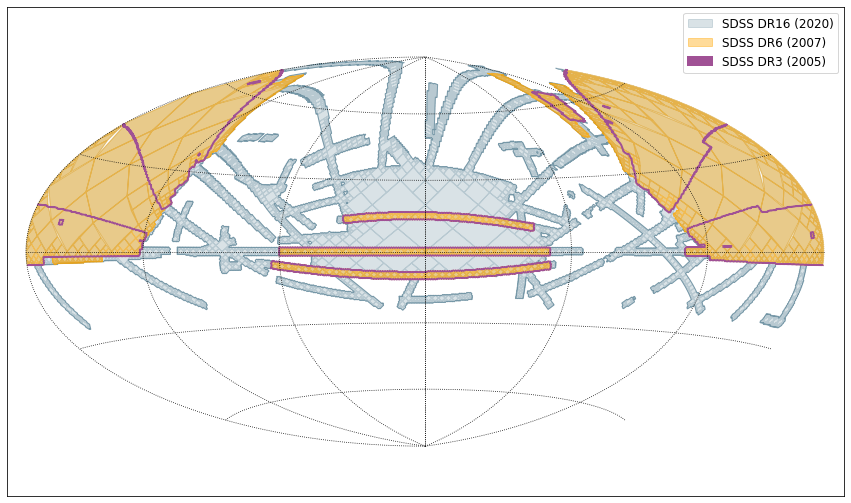

In [ ]:
fig = plt.figure(111,figsize=(15,9))

with World2ScreenMPL(fig,
                    fov = 340*u.deg,
                    center=SkyCoord(0,0,unit='deg',frame='icrs'),
                    coordsys='icrs', rotation=Angle(0, u.degree),
                    projection='AIT') as wcs:
    
    ax = fig.add_subplot(1,1,1,projection=wcs)

    moc_sdssdr16.fill(ax=ax, wcs=wcs, alpha=0.15, fill=True,color='#003f5c', label= 'SDSS DR16 (2020)')
    moc_sdssdr16.border(ax=ax, wcs=wcs, alpha=0.4, color='#003f5c')   
    
    moc_sdssdr6.fill(ax=ax, wcs=wcs, alpha=0.4, fill=True, color='#ffa600', label='SDSS DR6 (2007)')
    moc_sdssdr6.border(ax=ax, wcs=wcs, alpha=0.6, color='#ffa600')
    
    moc_sdssdr3.border(ax=ax, wcs=wcs, color='#a05195', lw=2, label='SDSS DR3 (2005)')

ax.legend(fontsize=12)
plt.grid(color='black', linestyle='dotted')

plt.show()

Now, we will plot the intersection of SDSS DR16 and J-PLUS DR2. For the latter, we will load the MOC from the corresponding FITS file, and then compute the intersection between both using the `intersection` MOCPy method.

In [ ]:
moc_jplusdr2 = MOC.from_fits("/content/jplus_dr2_moc.fits")

***Exercise 2:*** *Plot the J-PLUS DR2 MOC.*

In [ ]:
#@title
fig = plt.figure(111,figsize=(15,9))

with World2ScreenMPL(fig,
                    fov = 340*u.deg,
                    center=SkyCoord(0,0,unit='deg',frame='icrs'),
                    coordsys='icrs',rotation=Angle(0, u.degree),
                    projection='AIT') as wcs:
    
    ax = fig.add_subplot(1,1,1,projection=wcs)
    
    moc_jplusdr2.fill(ax=ax, wcs=wcs, alpha=0.5, fill=True,color='#ffa600')
    moc_jplusdr2.border(ax=ax, wcs=wcs, alpha=0.8,color='#ffa600')

ax.set_xlabel('RA',fontsize=16)
ax.set_ylabel('DEC',fontsize=16)
plt.title('J-PLUS DR2 sky coverage',fontsize=14)
plt.grid(color='black',linestyle='dotted')

plt.show()

In [ ]:
inter = moc_sdssdr16.intersection(moc_jplusdr2)

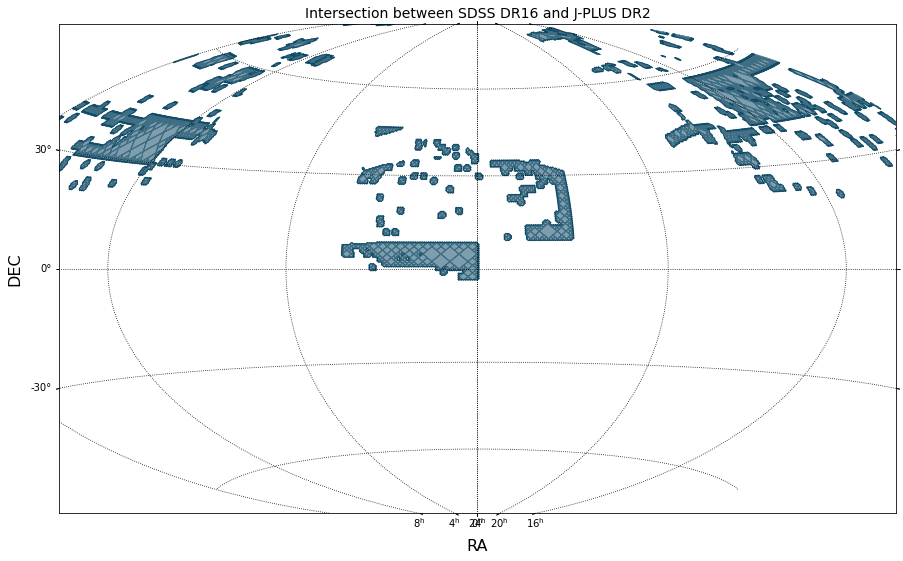

In [ ]:
fig = plt.figure(111,figsize=(15,9))

with World2ScreenMPL(fig,
                    fov = 260*u.deg,
                    center=SkyCoord(0,0,unit='deg',frame='icrs'),
                    coordsys='icrs',rotation=Angle(0, u.degree),
                    projection='AIT') as wcs:
    
    ax = fig.add_subplot(1,1,1,projection=wcs)
    
    inter.fill(ax=ax, wcs=wcs, alpha=0.5, fill=True,color='#003f5c')
    inter.border(ax=ax, wcs=wcs, alpha=0.8,color='#003f5c')      

ax.set_xlabel('RA',fontsize=16)
ax.set_ylabel('DEC',fontsize=16)
plt.title('Intersection between SDSS DR16 and J-PLUS DR2',fontsize=14)
plt.grid(color='black',linestyle='dotted')

plt.show()

***Exercise 3:*** *Compute and plot the union between SDSS DR16 and J-PLUS DR2*

In [ ]:
#@title
union = moc_sdssdr16.union(moc_jplusdr2)

fig = plt.figure(111,figsize=(15,9))

with World2ScreenMPL(fig,
                    fov = 260*u.deg,
                    center=SkyCoord(0,0,unit='deg',frame='icrs'),
                    coordsys='icrs',rotation=Angle(0, u.degree),
                    projection='AIT') as wcs:
    
    ax = fig.add_subplot(1,1,1,projection=wcs)
    
    union.fill(ax=ax, wcs=wcs, alpha=0.5, fill=True,color='#ffa600')
    union.border(ax=ax, wcs=wcs, alpha=0.8,color='#ffa600')      

ax.set_xlabel('RA',fontsize=16)
ax.set_ylabel('DEC',fontsize=16)
plt.title('Union between SDSS DR16 and J-PLUS DR2',fontsize=14)
plt.grid(color='black',linestyle='dotted')

plt.show()

warnings.filterwarnings("ignore", category=DeprecationWarning)

---

<h2><center> Real scientific case with MOCs </center></h2>

In this section, we will explore a real example in with the use of MOCs contributed to refine the scientific results of a [paper](https://arxiv.org/abs/2208.09377). For this, we will use the data from the [SVO archive of ultracool dwarfs identified in J-PLUS DR2](http://svocats.cab.inta-csic.es/jplus_ucds1/index.php?action=search), which contains information for the 9.810 candidate ultracool dwarfs identified using Virtual Observatory tools in the entire sky coverage of J-PLUS DR2.

In astronomy, when working with photometry from different surveys, you have to be sure that the photometry coming from each of them for the same filters/wavelengths is equivalent. This becomes very important when, for example, you are using the photometry of the stars to infer physical parameters such as the effective temperature. In our particular case, the use of the SDSS and J-PLUS DR2 MOCs allowed us to see that there was a significant difference between the density of objects identified in the regions where both MOCs overlapped and in regions where they did not. Looking further into this, we found a systematic difference between the photometry in SDSS and J-PLUS DR2 for the same filters that had to be corrected.

To reproduce this case, we will only need the coordinates of the objects, that are included in the file `UCD_data.csv`.

In [ ]:
data = pd.read_csv('UCD_data.csv')

data

,RA,DEC
0,282.86430,56.989800
1,282.67468,34.608840
2,153.25340,40.724920
3,283.04382,46.420483
4,283.04428,54.548317
...,...,...
9805,180.38774,40.778015
9806,330.08655,32.367640
9807,138.44522,58.265057
9808,198.66531,56.282790


When working with celestial coordinates, it is good practice to define them using the `SkyCoord` class of the `astropy` package, which provides a flexible interface for celestial coordinate representation, manipulation, and transformation between systems.

In [ ]:
coords = SkyCoord(data[['RA','DEC']].values,frame='icrs',unit='deg')
coords

<SkyCoord (ICRS): (ra, dec) in deg
    [(282.8643 , 56.9898  ), (282.67468, 34.60884 ),
     (153.2534 , 40.72492 ), ..., (138.44522, 58.265057),
     (198.66531, 56.28279 ), (216.02615, 79.383575)]>

We now plot the corresponding MOCs, including our objects in top of them.

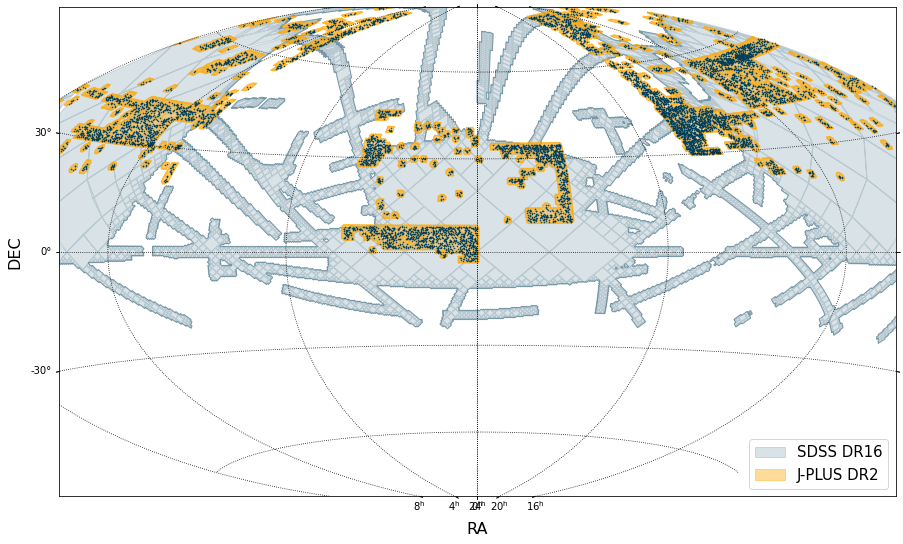

In [ ]:
fig = plt.figure(111, figsize=(15,9))

with World2ScreenMPL(fig, 
        fov=260* u.deg,
        center=SkyCoord(0, 0, unit='deg', frame='icrs'),
        coordsys="icrs",
        rotation=Angle(0, u.degree),
        projection="AIT") as wcs:
    
    ax = fig.add_subplot(1, 1, 1, projection=wcs)
    
    moc_sdssdr16.fill(ax=ax, wcs=wcs, alpha=0.15, fill=True, color='#003f5c',label='SDSS DR16')
    moc_sdssdr16.border(ax=ax, wcs=wcs, alpha=0.4, color='#003f5c')
    
    moc_jplusdr2.fill(ax=ax, wcs=wcs, alpha=0.4, fill=True, color="#ffa600",label='J-PLUS DR2')
    moc_jplusdr2.border(ax=ax, wcs=wcs, alpha=0.6, color="#ffa600")
    
    ax.scatter(coords.ra,coords.dec,marker='o',color='#003f5c',s=0.3,transform=ax.get_transform('world'))

ax.legend(fontsize=15)
ax.set_xlabel('RA',fontsize=16)
ax.set_ylabel('DEC',fontsize=16)
plt.grid(color="black", ls='dotted')

plt.show()

Zooming into a region where both MOCs overlap, we can check whether the density of objects is the same as in the non-overlapping regions.

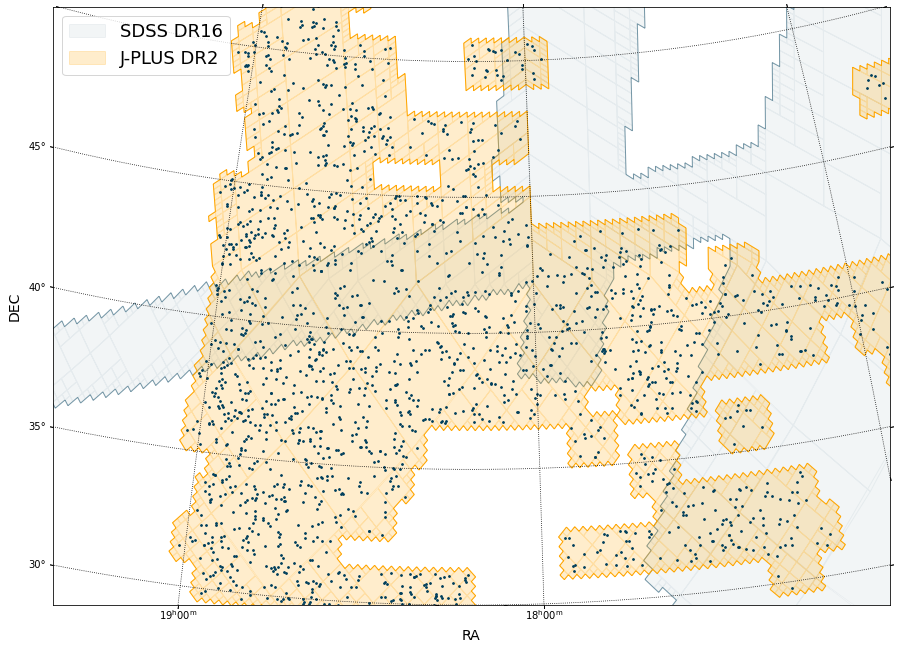

In [ ]:
fig = plt.figure(111, figsize=(15,11))

with World2ScreenMPL(fig, 
        fov=30 * u.deg,
        center=SkyCoord(273,41, unit='deg', frame='icrs'),
        coordsys="icrs",
        rotation=Angle(0, u.degree),
        projection="AIT") as wcs:
    
    ax = fig.add_subplot(1, 1, 1, projection=wcs)
    
    moc_sdssdr16.fill(ax=ax, wcs=wcs, alpha=0.05, fill=True, color='#003f5c',label='SDSS DR16')
    moc_sdssdr16.border(ax=ax, wcs=wcs, alpha=0.5, color='#003f5c')
    
    moc_jplusdr2.fill(ax=ax, wcs=wcs, alpha=0.2, fill=True, color='#ffa600',label='J-PLUS DR2')
    moc_jplusdr2.border(ax=ax, wcs=wcs, alpha=1, color='#ffa600')
    
    ax.scatter(coords.ra,coords.dec,marker='o',color='#003f5c',s=3,transform=ax.get_transform('world'))

ax.set_xlabel('RA',fontsize=14)
ax.set_ylabel('DEC',fontsize=14)
ax.legend(fontsize=18)
plt.grid(color="black", linestyle="dotted")

plt.show()

---

<h2><center> Query the 2MASS Catalogue by MOC </center></h2>
    
Without the usage of MOC, querying for sources in a specific region of the sky would be very tedious. Here, we will use the power of MOC files to query large catalogs directly in the covered regions only. We will use the MOC of the [MiniJ-PAS Public Data Release](http://www.j-pas.org/datareleases/minijpas_public_data_release_pdr201912), which covers a total area of $~\,1\,deg^2$, to query for sources from the 2MASS survey.

In [ ]:
moc_jpas = MOC.from_fits('/content/mini_jpas_moc.fits')

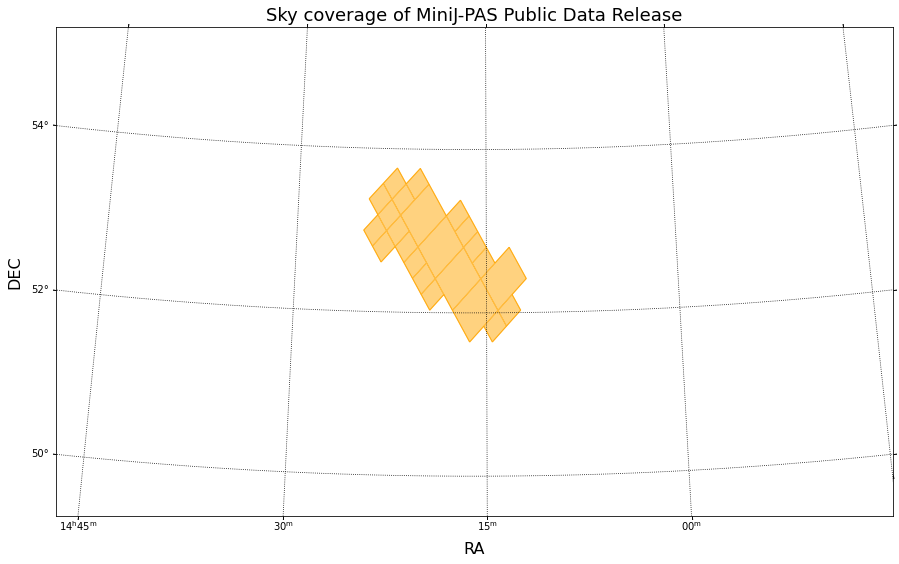

In [ ]:
fig = plt.figure(111,figsize=(15,9))

with World2ScreenMPL(fig,
                    fov = 10*u.deg,
                    center=SkyCoord(214,52.5,unit='deg',frame='icrs'),
                    coordsys='icrs',rotation=Angle(0, u.degree),
                    projection='AIT') as wcs:
    
    ax = fig.add_subplot(1,1,1,projection=wcs)
    
    moc_jpas.fill(ax=ax, wcs=wcs, alpha=0.5, fill='true',color='#ffa600')
    moc_jpas.border(ax=ax, wcs=wcs, alpha=0.8,color='#ffa600')
    
ax.set_xlabel('RA',fontsize=16)
ax.set_ylabel('DEC',fontsize=16)
plt.title('Sky coverage of MiniJ-PAS Public Data Release',fontsize=18)
plt.grid(color='black',linestyle='dotted')

plt.show()

To search for the table from the 2MASS survey containing the desired information, we will use the TAP protocol with the VizieR endpoint.

Through the VizieR TAP endpoint, we can explore the VizieR associated data service to search for tables, content of tables or information on data associated to the existing catalogues.

In [ ]:
tap_vizier = pyvo.dal.TAPService('http://tapvizier.u-strasbg.fr/TAPVizieR/tap')

query = '''
SELECT  *  FROM tap_schema.tables 
WHERE description LIKE '2MASS %source%'
'''

twomass_tables = tap_vizier.search(query).to_table()
twomass_tables

schema_name,table_name,table_type,description,utype,nrows
object,object,object,object,object,object
J_AJ,J/AJ/162/92/table3,table,"2MASS counterparts to XMM-Newton sources ( Evans N.R., Pillitteri I., Kervella P., Engle S., Guinan E., Gunther H.M., Wolk S., Neilson H., Marengo M., Matthews L.D., Moschou S., Drake J.J., Guzik J.A., Gallenne A., Merand A., Hocde V.)",,37
J_MNRAS,J/MNRAS/394/1875/table2,table,"2MASS photometry of MASH I and MASH II sources ( Phillips J.P., Zepeda-Garcia D.)",,60
J_ApJ,J/ApJ/715/671/phot,table,"2MASS and Spitzer photometry of the X-ray sources ( Wolk S.J., Winston E., Bourke T.L., Gutermuth R., Megeath S.T., Spitzbart B.D., Osten R.)",,158
large_tables,II/246/out,table,"2MASS Point Source Catalogue, output (on a total of 470,992,970 sources) ( Cutri R.M., Skrutskie M.F., Van Dyk S., et al.)",,470992970


The table we are looking for is `II/246/out`, which stores the 2MASS Point Source Catalog. We can query this table to have a look at its content.

In [ ]:
query = '''
SELECT Top 5 * FROM "II/246/out" 
'''

twomass_source_table = tap_vizier.search(query).to_table()
twomass_source_table

RAJ2000,DEJ2000,errMaj,errMin,errPA,2MASS,Jmag,Jcmsig,e_Jmag,Jsnr,Hmag,Hcmsig,e_Hmag,Hsnr,Kmag,Kcmsig,e_Kmag,Ksnr,Qflg,Rflg,Bflg,Cflg,Ndet,prox,pxPA,pxCntr,Xflg,Aflg,Cntr,Hemis,Date,Scan,GLON,GLAT,Xscan,JD,Jpsfchi,Hpsfchi,Kpsfchi,Jstdap,e_Jstdap,Hstdap,e_Hstdap,Kstdap,e_Kstdap,edgeNS,edgeEW,edge,dup,use,opt,Dopt,PAopt,Bmag,Rmag,Nopt,extKey,scanKey,coaddKey,coadd
deg,deg,arcsec,arcsec,deg,,mag,mag,mag,,mag,mag,mag,,mag,mag,mag,,,,,,,arcsec,deg,,,,,,,,deg,deg,arcsec,d,,,,mag,mag,mag,mag,mag,mag,arcsec,arcsec,,,,,arcsec,deg,mag,mag,,,,,
float64,float64,float32,float32,int16,object,float32,float32,float32,float64,float32,float32,float32,float64,float32,float32,float32,float64,object,object,object,object,object,float32,int16,int64,int16,int16,int64,str1,object,int16,float32,float32,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,int16,object,int16,int16,str1,float32,int16,float32,float32,int16,int32,int32,int32,int16
44.996055,0.005565,0.17,0.16,76,02595905+0000200,16.376,0.097,0.097,11.3,15.77,0.139,0.14,8.2,15.258,0.141,0.141,7.6,ABB,222,111,000,060606,44.5,230,1290669337,0,0,1290669325,s,1998-09-28,112,176.951,-48.902,-138.9,2451084.8062,0.75,1.21,1.13,16.651,0.221,15.434,0.134,15.478,0.434,521,114,ne,1,1,U,0.7,156,17.9,16.9,1,--,69347,1594959,9
45.004857,0.019806,0.06,0.06,90,03000116+0001113,12.529,0.021,0.024,389.8,11.954,0.029,0.03,273.7,11.874,0.027,0.029,172.5,AAA,222,111,000,666666,4.8,330,1290669298,0,0,1290669300,s,1998-09-28,112,176.945,-48.885,-170.6,2451084.8062,1.15,1.31,1.97,12.508,0.019,11.91,0.025,11.852,0.008,469,82,ne,1,1,U,1.5,72,15.0,13.8,1,--,69347,1594959,9
45.004193,0.020956,0.06,0.06,90,03000100+0001154,14.845,0.055,0.056,46.2,14.223,0.077,0.077,33.9,14.016,0.055,0.055,24.0,AAA,222,111,ccc,666666,4.8,150,1290669300,0,0,1290669298,s,1998-09-28,112,176.943,-48.885,-168.2,2451084.8062,0.86,0.89,1.11,13.889,0.101,13.035,0.126,12.97,0.043,465,84,ne,1,1,0,--,--,--,--,0,--,69347,1594959,9
44.995074,0.038204,0.38,0.31,0,02595881+0002175,16.746,0.133,0.134,8.0,15.814,0.139,0.14,7.8,16.125,0.324,0.324,3.4,BBD,222,111,000,060606,70.2,152,1290669298,0,0,1290669276,s,1998-09-28,112,176.914,-48.88,-135.4,2451084.8062,1.22,0.84,0.69,17.047,0.414,15.5,0.229,17.513,1.964,403,117,ne,0,1,0,--,--,--,--,0,--,69347,1594959,9
44.963851,0.043587,0.22,0.17,95,02595132+0002369,16.476,0.112,0.113,10.3,16.057,0.175,0.175,6.3,15.564,--,--,--,BCU,220,110,000,060600,89.4,207,1290669295,0,0,1290669271,s,1998-09-28,112,176.875,-48.898,-23.0,2451084.8062,1.13,1.07,--,17.113,0.34,18.739,3.527,--,--,384,229,ne,1,1,U,0.4,161,18.7,17.7,1,--,69347,1594959,9


***Exercise 4:*** *Another way to search for the 2MASS catalogues available on VizieR is to use the `Vizier` module in the `astroquery` package, as we did before. Find the desired table `II/246/out` using this module.*

In [ ]:
#@title
catalog_list_twomass = Vizier.find_catalogs('2MASS source')
for k, v in catalog_list_twomass.items():
    print(k, ': ', v.description)

warnings.filterwarnings('ignore')

In [ ]:
#@title
table_list_twomass = Vizier.get_catalogs('II/246')

print(table_list_twomass)

Once we have found the target table `II/246/out`, we can use the `query_vizier_table` MOCPy method to query this table and search for sources in the coverage of the MOC instance.

In [ ]:
twomass_sources = moc_jpas.query_vizier_table('II/246/out')

twomass_sources

_2MASS,RAJ2000,DEJ2000,errHalfMaj,errHalfMin,errPosAng,Jmag,Hmag,Kmag,e_Jmag,e_Hmag,e_Kmag,Qfl,Rfl,X,MeasureJD
,deg,deg,arcsec,arcsec,deg,mag,mag,mag,mag,mag,mag,,,,d
str17,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,str3,int16,uint8,float64
14143901+5140318,213.662572,51.675522,0.2,0.18,64.0,16.635,15.896,15.084,0.127,0.146,0.116,BBB,222,0,2451604.8572
14142374+5141046,213.598927,51.684624,0.32,0.25,161.0,16.394,16.312,15.247,--,0.232,0.126,UDB,22,0,2451604.8572
14142405+5140229,213.600233,51.673046,0.12,0.08,90.0,14.463,13.82,13.605,0.033,0.04,0.041,AAA,222,0,2451604.8572
14142800+5141234,213.616695,51.689842,0.13,0.1,89.0,16.318,15.419,14.98,0.112,0.113,0.116,BBB,222,0,2451604.8572
14142463+5141219,213.602664,51.689423,0.23,0.22,37.0,16.958,15.982,15.668,0.191,0.168,0.178,CCC,222,0,2451604.8572
14142111+5142212,213.587965,51.70591,0.26,0.25,28.0,16.895,16.235,15.403,0.17,0.211,0.135,CCB,222,0,2451604.8572
14142863+5141522,213.619303,51.697845,0.16,0.12,88.0,15.907,15.688,15.429,0.081,0.118,0.16,ABC,222,0,2451604.8572
14143155+5143075,213.631475,51.718754,0.25,0.21,7.0,16.786,15.761,15.206,0.172,0.13,0.128,CBB,222,0,2451604.8572


As seen below, the search has been performed accurately throughout the entire sky coverage of MiniJ-PAS Public Data Release.

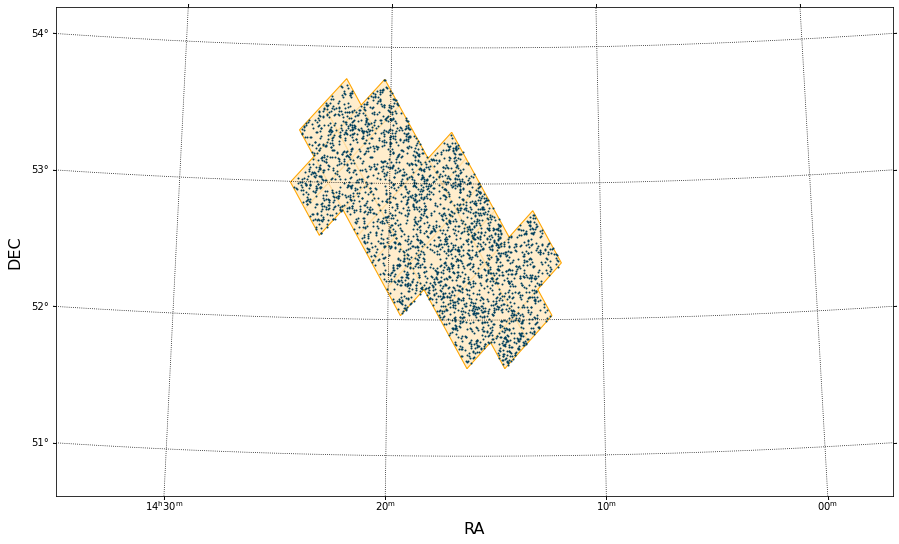

In [ ]:
coords = SkyCoord(twomass_sources['RAJ2000'].data,twomass_sources['DEJ2000'].data,frame="icrs", unit="deg")

fig = plt.figure(111,figsize=(15,9))

with World2ScreenMPL(fig,
                    fov = 6*u.deg,
                    center=SkyCoord(214,52.5,unit='deg',frame='icrs'),
                    coordsys='icrs',rotation=Angle(0, u.degree),
                    projection='AIT') as wcs:
    
    ax = fig.add_subplot(1,1,1,projection=wcs)
    
    moc_jpas.fill(ax=ax, wcs=wcs, alpha=0.2, fill='true',color='#ffa600')
    moc_jpas.border(ax=ax, wcs=wcs, alpha=1,color='#ffa600')
    

ax.scatter(twomass_sources['RAJ2000'],twomass_sources['DEJ2000'],marker='o',s=1,c='#003f5c',transform=ax.get_transform('world'))

ax.set_xlabel('RA',fontsize=16)
ax.set_ylabel('DEC',fontsize=16)
plt.grid(color='black',linestyle='dotted')

plt.show()